In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !pip install tensorflow-gpu

In [3]:
import cudf as cd
import cupy as cp
import tensorflow as tf
from tensorflow import keras as k
import cuml
import numpy as np
import pandas as pd

In [4]:
train_img_names = cd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv')

In [5]:
train_img_names.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [6]:
train_img_names.shape

(22424, 3)

In [7]:
train_img_names.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 676.9+ KB


In [8]:
train_img_names['subject'].unique()

0     p002
1     p012
2     p014
3     p015
4     p016
5     p021
6     p022
7     p024
8     p026
9     p035
10    p039
11    p041
12    p042
13    p045
14    p047
15    p049
16    p050
17    p051
18    p052
19    p056
20    p061
21    p064
22    p066
23    p072
24    p075
25    p081
Name: subject, dtype: object

In [9]:
train_img_names['classname'].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int32

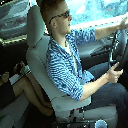

In [10]:
from keras.preprocessing import image 
img = image.load_img('../input/state-farm-distracted-driver-detection/imgs/train/c0/img_100026.jpg', 
        target_size = (128, 128))
img

In [11]:
img = image.img_to_array(img)
img.shape

(128, 128, 3)

In [12]:
train_img_names.drop('subject', 1, inplace = True)

In [13]:
dic = {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}
classes = [dic[str(i)] for i in train_img_names['classname'].to_arrow()]
train_img_names['classname'] = classes
train_img_names.head()

,classname,img
0,0,img_44733.jpg
1,0,img_72999.jpg
2,0,img_25094.jpg
3,0,img_69092.jpg
4,0,img_92629.jpg


In [14]:
x = train_img_names['img'].to_pandas()
y = train_img_names['classname'].to_pandas()

In [15]:
from sklearn.model_selection import train_test_split as tts
x_train, x_test, y_train, y_test = tts(x, y, test_size = 0.3, random_state = 42)

In [16]:
x_train.head()

19338    img_50751.jpg
15692      img_569.jpg
20677    img_33604.jpg
7220     img_64545.jpg
13094    img_74652.jpg
Name: img, dtype: object

In [17]:
x_train = cd.DataFrame(x_train.reset_index())
x_test = cd.DataFrame(x_test.reset_index())
y_train = cd.DataFrame(y_train.reset_index())
y_test = cd.DataFrame(y_test.reset_index())

In [18]:
def image_rgb(image_name, cl):
    path = '../input/state-farm-distracted-driver-detection/imgs/train/' + 'c' + str(cl) + '/' + image_name
    mImage = image.load_img(path,target_size = (64, 64))
    mImage = image.img_to_array(mImage)
    return mImage

In [19]:
xtrain = [image_rgb(x_train['img'][i], y_train['classname'][i]) for i in range(len(x_train))]
xtest = [image_rgb(x_test['img'][i], y_test['classname'][i]) for i in range(len(x_test))]

In [20]:
xtrain = np.array(xtrain)
xtest = np.array(xtest)

In [21]:
xtrain.shape

(15696, 64, 64, 3)

In [22]:
xtr = xtrain / 255.0
xte = xtest / 255.0

In [23]:
model = k.Sequential()
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2,padding='same', activation='relu', input_shape=(64,64,3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2,padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2,padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2,padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        16448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          1

2022-03-16 19:38:36.431599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 19:38:36.436976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 19:38:36.437620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 19:38:36.438638: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [24]:
y_test = y_test.to_pandas().to_numpy()
y_train = y_train.to_pandas().to_numpy()

In [25]:
y_train = y_train[:, 1]
y_test = y_test[:, 1]

In [26]:
y_test

array([2, 5, 6, ..., 0, 3, 6])

In [27]:
y_train = k.utils.to_categorical(y_train)

In [28]:
y_test = k.utils.to_categorical(y_test)

In [29]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(xtr, y_train,epochs=20, validation_data = (xte, y_test), batch_size=32)

2022-03-16 19:38:37.341791: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 771489792 exceeds 10% of free system memory.
2022-03-16 19:38:38.142618: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 771489792 exceeds 10% of free system memory.
2022-03-16 19:38:38.712004: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-03-16 19:38:40.072527: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


491/491 [==============================] - 12s 10ms/step - loss: 1.4362 - accuracy: 0.4709 - val_loss: 0.5694 - val_accuracy: 0.8221
Epoch 2/20
491/491 [==============================] - 4s 8ms/step - loss: 0.5503 - accuracy: 0.8191 - val_loss: 0.2254 - val_accuracy: 0.9438
Epoch 3/20
491/491 [==============================] - 5s 9ms/step - loss: 0.3070 - accuracy: 0.9030 - val_loss: 0.1160 - val_accuracy: 0.9716
Epoch 4/20
491/491 [==============================] - 4s 8ms/step - loss: 0.2239 - accuracy: 0.9293 - val_loss: 0.1070 - val_accuracy: 0.9747
Epoch 5/20
491/491 [==============================] - 4s 8ms/step - loss: 0.1735 - accuracy: 0.9453 - val_loss: 0.0670 - val_accuracy: 0.9828
Epoch 6/20
491/491 [==============================] - 4s 9ms/step - loss: 0.1505 - accuracy: 0.9537 - val_loss: 0.0616 - val_accuracy: 0.9837
Epoch 7/20
491/491 [==============================] - 4s 8ms/step - loss: 0.1199 - accuracy: 0.9620 - val_loss: 0.0430 - val_accuracy: 0.9891
Epoch 8/20
491/